<a href="https://colab.research.google.com/github/Shankar-Hadimani/ai-ml-engineering/blob/master/notebook/05_multiclass_sentiment_analysis_using_Auto_ViML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install autoviml

"""
Using this autoviml to directly predicting classification without applu=ying any feature engineering and cleansing on NLP dataset
-- stemming, tokeinization and stop words are also not remooved.
-- based on automviuml, we can understnad the intuition about the model, that can be used along with additional parameter tuning
"""

     |████████████████████████████████| 122kB 9.0MB/s 
     |████████████████████████████████| 6.8MB 12.9MB/s 
     |████████████████████████████████| 133kB 49.2MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 66.3MB 56kB/s 
     |████████████████████████████████| 327kB 43.9MB/s 
     |████████████████████████████████| 148.9MB 89kB/s 
     |████████████████████████████████| 174kB 47.4MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=07333631ae45633973c2122d658c9a5466ff5cda49539e13719324ad9adda669
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463911 sha256=d34869fc526720814e074fc12460f8cb6b78273f8ff5c32426aef1bd9f487f2a
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built emoji shap
  Fo

In [3]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
dataset, info  = tfds.load('amazon_us_reviews/Personal_Care_Appliances_v1_00',with_info=True, batch_size=-1)
train_dataset = dataset['train']

Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0.incompleteCLQ9R0/amazon_us_reviews-train.tfrecord


Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0. Subsequent calls will reuse this data.


In [5]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

In [6]:
dataset = tfds.as_numpy(train_dataset)
dataset

{'data': {'customer_id': array([b'13986323', b'50574716', b'50593972', ..., b'40719682',
         b'35596948', b'29430209'], dtype=object),
  'helpful_votes': array([0, 3, 0, ..., 0, 0, 0], dtype=int32),
  'marketplace': array([b'US', b'US', b'US', ..., b'US', b'US', b'US'], dtype=object),
  'product_category': array([b'Personal_Care_Appliances', b'Personal_Care_Appliances',
         b'Personal_Care_Appliances', ..., b'Personal_Care_Appliances',
         b'Personal_Care_Appliances', b'Personal_Care_Appliances'],
        dtype=object),
  'product_id': array([b'B00847JQZ6', b'B00N5HD340', b'B0077L1X24', ..., b'B000UZ8X2W',
         b'B000NURPPK', b'B001EY5GNW'], dtype=object),
  'product_parent': array([b'997683625', b'955577225', b'120764066', ..., b'96066145',
         b'58591097', b'986877728'], dtype=object),
  'product_title': array([b'SE - Reading Glass - Spring Loaded Hinges, 4.0x - RTS62400',
         b'Straight Razor',
         b'Philips Sonicare Flexcare & Healthy White Plastic

In [9]:
### select features
star_rating=dataset['data']['star_rating']
helpful_votes=dataset['data']['helpful_votes']
total_votes=dataset['data']['total_votes']
verified_purchase=dataset['data']['verified_purchase']
review_headline=dataset['data']['review_headline']
review_body=dataset['data']['review_body']

In [16]:
### create a pandas dataframe from above features
reviews_df = pd.DataFrame(np.hstack((star_rating[:,None],
                                     helpful_votes[:,None], 
                                     total_votes[:,None],
                                     verified_purchase[:,None],
                                     review_headline[:,None],
                                     review_body[:,None])),
                          columns=['star_rating', 'helpful_votes','total_votes', 'verified_purchase','review_headline', 'review_body']
                          )

In [17]:
### define schema
schema_dict = {'star_rating':int,
               'helpful_votes':int,
               'total_votes':int,
               'verified_purchase':int,
               'review_headline':str,
               'review_body':str,
               }

In [18]:
### apply schema tot the dataframe
reviews_df = reviews_df.astype(schema_dict)


In [19]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85981 entries, 0 to 85980
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   star_rating        85981 non-null  int64 
 1   helpful_votes      85981 non-null  int64 
 2   total_votes        85981 non-null  int64 
 3   verified_purchase  85981 non-null  int64 
 4   review_headline    85981 non-null  object
 5   review_body        85981 non-null  object
dtypes: int64(4), object(2)
memory usage: 3.9+ MB


In [20]:
### create to filter multiple target classifiers
def convert_target_rating(rating):
  if rating <= 2:
    val = 0
  elif rating == 3:
    val = 1
  else:
    val = 2
  
  return val

In [21]:
### add a label / target column apply multiple classifier targets
reviews_df['target'] = reviews_df['star_rating'].apply(lambda x: convert_target_rating(x))

In [23]:
### view target/label distribution in the dataset
reviews_df['target'].value_counts()

2    62554
0    16377
1     7050
Name: target, dtype: int64

In [25]:
### drop the rating column as label column is already been added
reviews_df = reviews_df.drop('star_rating', axis=1)

In [26]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85981 entries, 0 to 85980
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   helpful_votes      85981 non-null  int64 
 1   total_votes        85981 non-null  int64 
 2   verified_purchase  85981 non-null  int64 
 3   review_headline    85981 non-null  object
 4   review_body        85981 non-null  object
 5   target             85981 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.9+ MB


In [27]:
### split the train and test datasets
train_ds, test_ds = train_test_split(reviews_df, test_size=0.25)

In [28]:
""" 
1. extract target column
2. apply autoviml automl algorithm 
"""
from autoviml.Auto_ViML import Auto_ViML

target_column = 'target'

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (64485, 6)
    Training Set Memory Usage = 3.44 MB
Test Set Shape = (21496, 6)
    Test Set Memory Usage = 1.15 MB
Single_Label Target: ['target']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
ALERT! Setting Imbalanced_Flag to True in Auto_ViML for Multi_Classification problems improves results!
       Class  -> Counts -> Percent
           0:   12308  ->   19.1%
           1:    5256  ->    8.2%
           2:   46921  ->   72.8%
CAUTION: In Multi-Class Boosting (2+ classes), TRAINING WILL TAKE A LOT OF TIME!
    Target target is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  0
    Number of Integer-Categorical Columns =  2
    Number of String-Categorical Co

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.068801


0:	test: 0.5326501	best: 0.5326501 (0)	total: 173ms	remaining: 11m 30s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.7432941915
bestIteration = 82

Shrink model to first 83 iterations.
    Actual training time (in seconds): 6
###########  Single_Label  M O D E L   R E S U L T S #################
5-fold Cross Validation logloss = 0.7432941914833502
    CatBoost Best Parameters for Model: Iterations = 82, learning_rate = 0.07
########################################################
CatBoost Model Prediction Results on Held Out CV Data Set:
Multi Class Model Metrics Report
#####################################################
    Accuracy          = 78.0%
    Balanced Accuracy (average recall) = 45.3%
    Average Precision (macro) = 83.8%
    Precisions by class:
    90.1%      84.1%      77.3%  
    Recall Scores by class:
    23.7%      12.6%      99.6%  
    F1 Scores by class:
    37.5%      21.9%      87.1%  
#####################################################

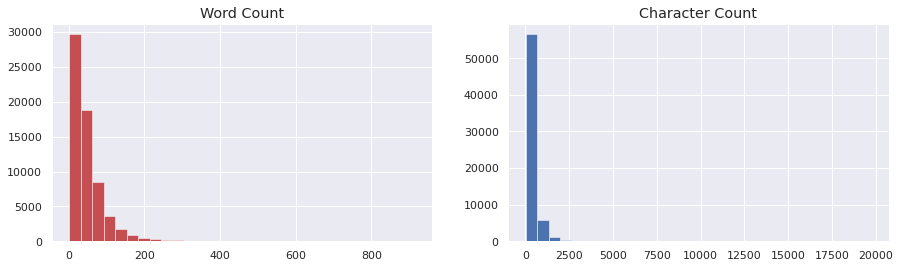

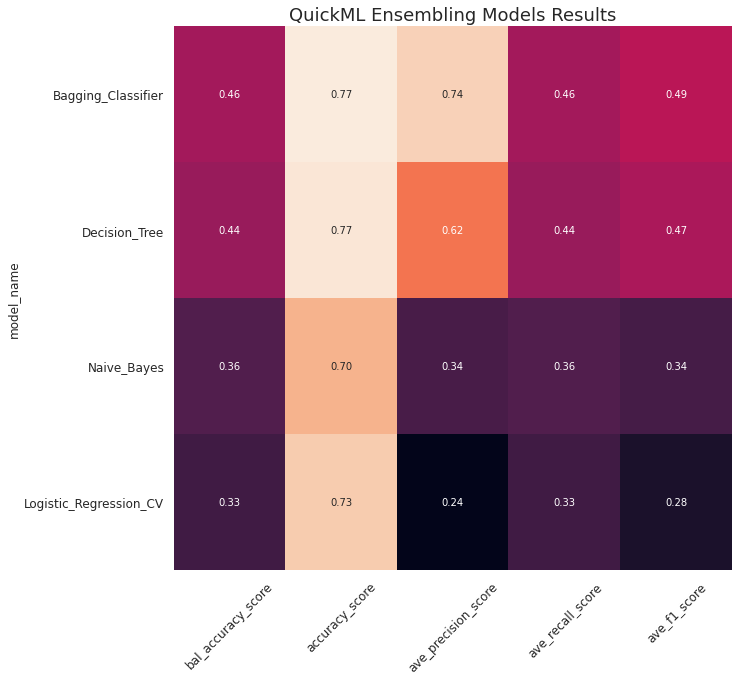

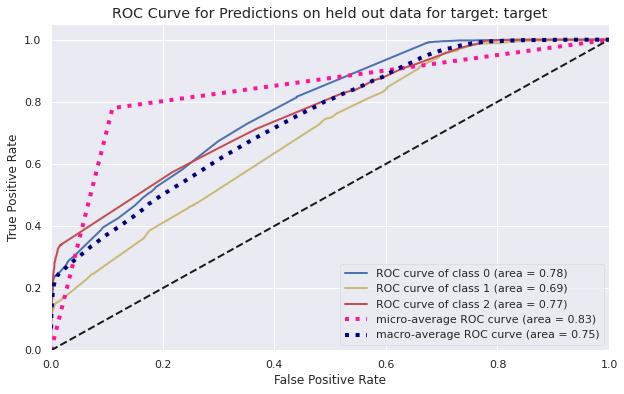

Average precision score, micro-averaged over all classes: 0.83
Macro F1 score, averaged over all classes: 0.49


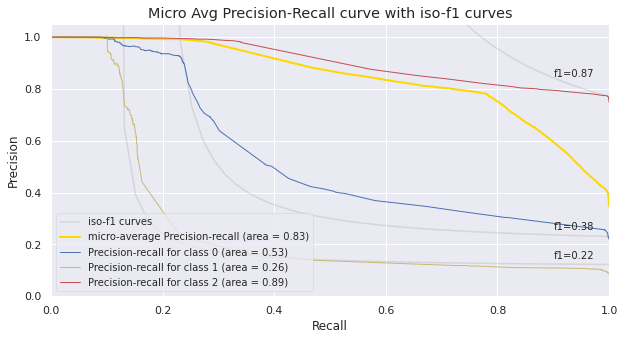

After multiple models, Ensemble Model Results:
Multi Class Model Metrics Report
#####################################################
    Accuracy          = 75.6%
    Balanced Accuracy (average recall) = 41.4%
    Average Precision (macro) = 65.4%
    Precisions by class:
    92.9%      25.7%      77.5%  
    Recall Scores by class:
    10.7%      14.0%      99.5%  
    F1 Scores by class:
    19.2%      18.1%      87.1%  
#####################################################
              precision    recall  f1-score   support

           0       0.93      0.11      0.19      2462
           1       0.26      0.14      0.18      1051
           2       0.78      0.99      0.87      9384

    accuracy                           0.76     12897
   macro avg       0.65      0.41      0.41     12897
weighted avg       0.76      0.76      0.69     12897

[[ 263  376 1823]
 [  19  147  885]
 [   1   49 9334]]
#############################################################################
Sing

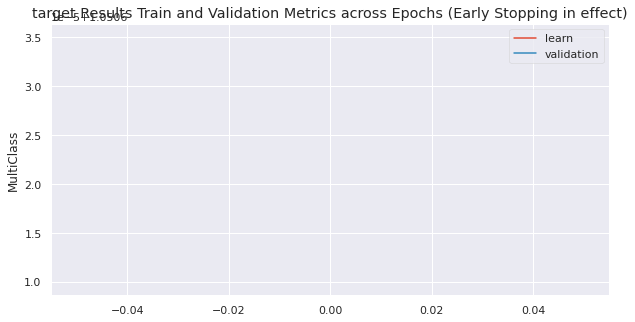

    Time taken for this Target (in seconds) = 501
    Binning_Flag set to False or there are no float vars in data set to be binned
    Setting best params for CatBoost model from Initial State since you cannot change params to a fitted Catboost model 
    Number of Categorical and Integer variables used in CatBoost training = 3
No MinMax scaling performed since scaling flag is set to false
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
0:	total: 61.1ms	remaining: 4.95s
81:	total: 5.01s	remaining: 0us
     Actual Training time taken in seconds = 5
Training of models completed. Now starting predictions on test data...
    Calculating weighted average ensemble of 5 classifiers
Plotting Feature Importances to explain the output of model
############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 527
Writing Output files to disk...
    Saving predictions to ./target/target_Multi_Cl

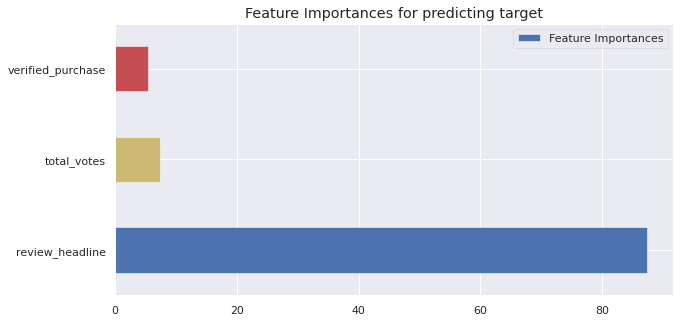

In [30]:
"""
use Cat Boosting wiht Random Search for Hyper parameter optimisation
"""
model, features, train_m, test_m  = Auto_ViML(train=train_ds,
                                              target=target_column,
                                              test=test_ds,
                                              hyper_param='RS',
                                              Boosting_Flag='CatBoost',
                                              Stacking_Flag=False, 
                                              Imbalanced_Flag=False, 
                                              verbose=1, 
                                              KMeans_Featurizer=False,
                                              feature_reduction=True,
                                              sample_submission='')

In [31]:
features

['review_headline', 'verified_purchase', 'total_votes']

In [32]:
test_m

,review_headline,verified_purchase,total_votes,target_proba_0,target_proba_1,target_proba_2,target_predictions,target_Logistic_Regression_CV_predictions,target_Decision_Tree_predictions,target_Naive_Bayes_predictions,target_Bagging_Classifier_predictions,target_CatBoost_predictions,target_Ensembled_predictions
43908,13023,0,1,0.20,0.10,0.70,2,2,0,2,0,2,2
73508,32859,0,0,0.16,0.09,0.76,2,2,2,2,2,2,2
21343,35575,1,11,0.28,0.08,0.64,2,2,2,0,0,2,2
78367,52686,0,0,0.16,0.09,0.76,2,2,2,2,0,2,2
73551,1655,0,0,0.16,0.09,0.76,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75649,31271,0,6,0.23,0.10,0.67,2,2,2,2,2,2,2
82774,30457,0,3,0.23,0.10,0.67,2,2,2,2,2,2,2
70216,49660,0,0,0.00,0.02,0.98,2,2,2,2,2,2,2
39505,49698,0,0,0.00,0.01,0.99,2,2,2,2,2,2,2


In [35]:
### save the model as CatBosstModel format
model.save_model('model', format='cbm')

In [37]:
!ls -ltr

total 2240
drwxr-xr-x 1 root root    4096 Nov 13 17:33 sample_data
drwxr-xr-x 5 root root    4096 Dec  2 19:05 catboost_info
drwxr-xr-x 2 root root    4096 Dec  2 19:06 target
-rw-r--r-- 1 root root 2281296 Dec  2 19:13 model


In [41]:
### predict model accuracy against test dataset from saved model.
model.predict(test_m[features])

array([[2],
       [2],
       [2],
       ...,
       [2],
       [2],
       [2]])

In [40]:
from autoviml.Auto_NLP import plot_confusion_matrix, plot_classification_matrix

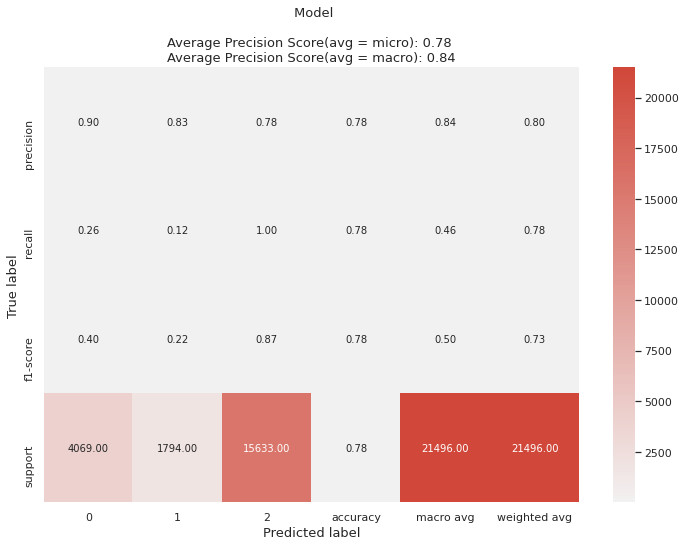

In [44]:
### plot the clasifcation matrix matrix 
plot_classification_matrix(test_ds['target'].values, model.predict(test_m[features]))

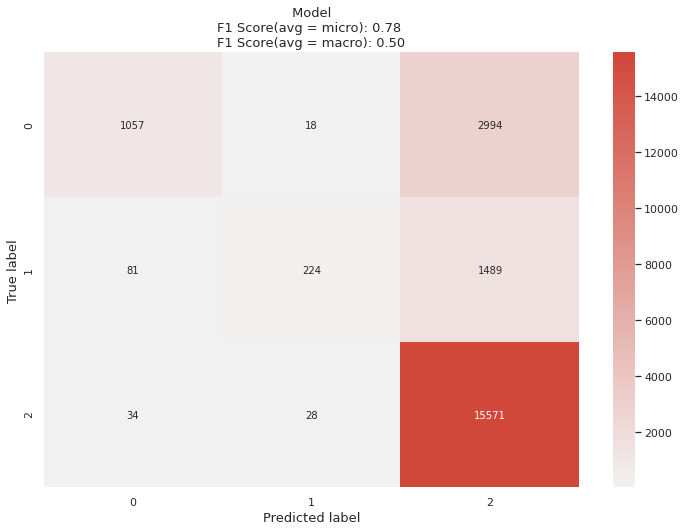

In [45]:
### plot the confusion matrix to understand the true/ false/ error loss
plot_confusion_matrix(test_ds['target'].values, model.predict(test_m[features]))